In [94]:
%matplotlib notebook
%matplotlib inline
import numpy as np, pandas as pd
from matplotlib import pyplot as plt

In [126]:
files=!ls *.txt 
print(files)

['IspraHome-Day-0630ToXXXX-20160908.txt', 'IspraHome-Day-1000ToXXXX-20160907.txt', 'IspraHome-Night-0200ToXXXX-20160909.txt', 'IspraHome-Night-2100To1000-20160906.txt', 'IspraHome-Night-2100ToXXXX-20160908.txt']


In [202]:
import io
import re

regexs = (
    (re.compile(r'cpm = (?P<clicks>\d+)'), lambda c: c / 6),
    (re.compile(r'.*cpm=\d+, clicks=(?P<clicks>\d+).*'), None),
    (re.compile(r'.*(?P<clicks>\d+),(?P<maxcpm>\d+.\d+)'), None),
)
def parse_click_line(l):
    for r, click_fun in regexs:
        m = r.search(l)
        if m: 
            res = m.groupdict()
            
            clicks = res['clicks']
            assert str(clicks) == str(int(clicks)), clicks
            clicks = int(clicks)
            if click_fun:
                clicks = click_fun(clicks)
                
            maxcpm = res.get('maxcpm', 0.0)
            if maxcpm:
                maxcpm = float(maxcpm)
            return clicks, maxcpm

def read_clicks(file):
    """:return: Nx1 or Nx2 matrix if 'maxcpm' exists"""
    with io.open(file, 'rt') as fd:
        lines = (parse_click_line(l) for l in fd if l)
        return np.array([l for l in lines if l])

# f='IspraHome-Night-0200ToXXXX-20160909.txt'
# read_clicks(f)

# file_clicks = {f: read_clicks(f) for f in files}
# file_clicks

In [154]:
from datetime import datetime
fname_re = re.compile(r'-(\d{4})to.+-(\d{8})', re.I)
def parse_fname_time(file):
    m = fname_re.search(file)
    if m:
        tm = '%s%s' %(m.group(2), m.group(1))
        tm = datetime.strptime(tm, '%Y%m%d%H%M')
        return tm

    
# file_times = {f: parse_fname_time(f) for f in files}
# file_times = {k:v for k,v in file_times.items() if v}
# file_times

{'IspraHome-Day-0630ToXXXX-20160908.txt': datetime.datetime(2016, 9, 8, 6, 30),
 'IspraHome-Day-1000ToXXXX-20160907.txt': datetime.datetime(2016, 9, 7, 10, 0),
 'IspraHome-Night-0200ToXXXX-20160909.txt': datetime.datetime(2016, 9, 9, 2, 0),
 'IspraHome-Night-2100To1000-20160906.txt': datetime.datetime(2016, 9, 6, 21, 0),
 'IspraHome-Night-2100ToXXXX-20160908.txt': datetime.datetime(2016, 9, 8, 21, 0)}

In [203]:
def zipdict(*dcts):
    for i in set(dcts[0]).intersection(*dcts[1:]):
            yield (i, tuple(d[i] for d in dcts))

# file_data = zipdict(file_times, file_clicks)
# file_data = sorted(file_data, key=lambda v: v[1][0])

def collect_data(files):
    file_clicks = {f: read_clicks(f) for f in files}
    #print([v.shape for v in file_clicks.values()])
    
    file_times = {f: parse_fname_time(f) for f in files}
    file_times = {k:v for k,v in file_times.items() if v}

    file_data = zipdict(file_times, file_clicks)
    file_data = sorted(file_data, key=lambda v: v[1][0])

    return file_data

file_data = collect_data(files)

In [204]:
from collections import OrderedDict

def file_df(fname, stime, clicks):
    ix = pd.date_range(stime, periods=clicks.shape[0], freq='10S')

    df = pd.DataFrame(clicks, index=ix, columns=['clicks', 'maxcpm'])
    df.name = fname
    return df

file_data = collect_data(files)
dfs = OrderedDict((f, file_df(f, stime, clicks)) 
         for f, (stime, clicks) in file_data)

df = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
df.head()

IspraHome-Night-2100To1000-20160906.txt         \
                                                     clicks maxcpm   
2016-09-06 21:00:00                                     3.0    0.0   
2016-09-06 21:00:10                                     0.0    0.0   
2016-09-06 21:00:20                                     3.0    0.0   
2016-09-06 21:00:30                                     3.0    0.0   
2016-09-06 21:00:40                                     4.0    0.0   

                    IspraHome-Day-1000ToXXXX-20160907.txt         \
                                                   clicks maxcpm   
2016-09-06 21:00:00                                   NaN    NaN   
2016-09-06 21:00:10                                   NaN    NaN   
2016-09-06 21:00:20                                   NaN    NaN   
2016-09-06 21:00:30                                   NaN    NaN   
2016-09-06 21:00:40                                   NaN    NaN   

                    IspraHome-Day-0630ToXXXX-20160908.txt         \
                                                   clicks maxcpm   
2016-09-06 21:00:00                                   NaN    NaN   
2016-09-06 21:00:10                                   NaN    NaN   
2016-09-06 21:00:20                                   NaN    NaN   
2016-09-06 21:00:30                                   NaN    NaN   
2016-09-06 21:00:40                                   NaN    NaN   

                    IspraHome-Night-2100ToXXXX-20160908.txt         \
                                                     clicks maxcpm   
2016-09-06 21:00:00                                     NaN    NaN   
2016-09-06 21:00:10                                     NaN    NaN   
2016-09-06 21:00:20                                     NaN    NaN   
2016-09-06 21:00:30                                     NaN    NaN   
2016-09-06 21:00:40                                     NaN    NaN   

                    IspraHome-Night-0200ToXXXX-20160909.txt         
                                                     clicks maxcpm  
2016-09-06 21:00:00                                     NaN    NaN  
2016-09-06 21:00:10                                     NaN    NaN  
2016-09-06 21:00:20                                     NaN    NaN  
2016-09-06 21:00:30                                     NaN    NaN  
2016-09-06 21:00:40                                     NaN    NaN

<IPython.core.display.Javascript object>


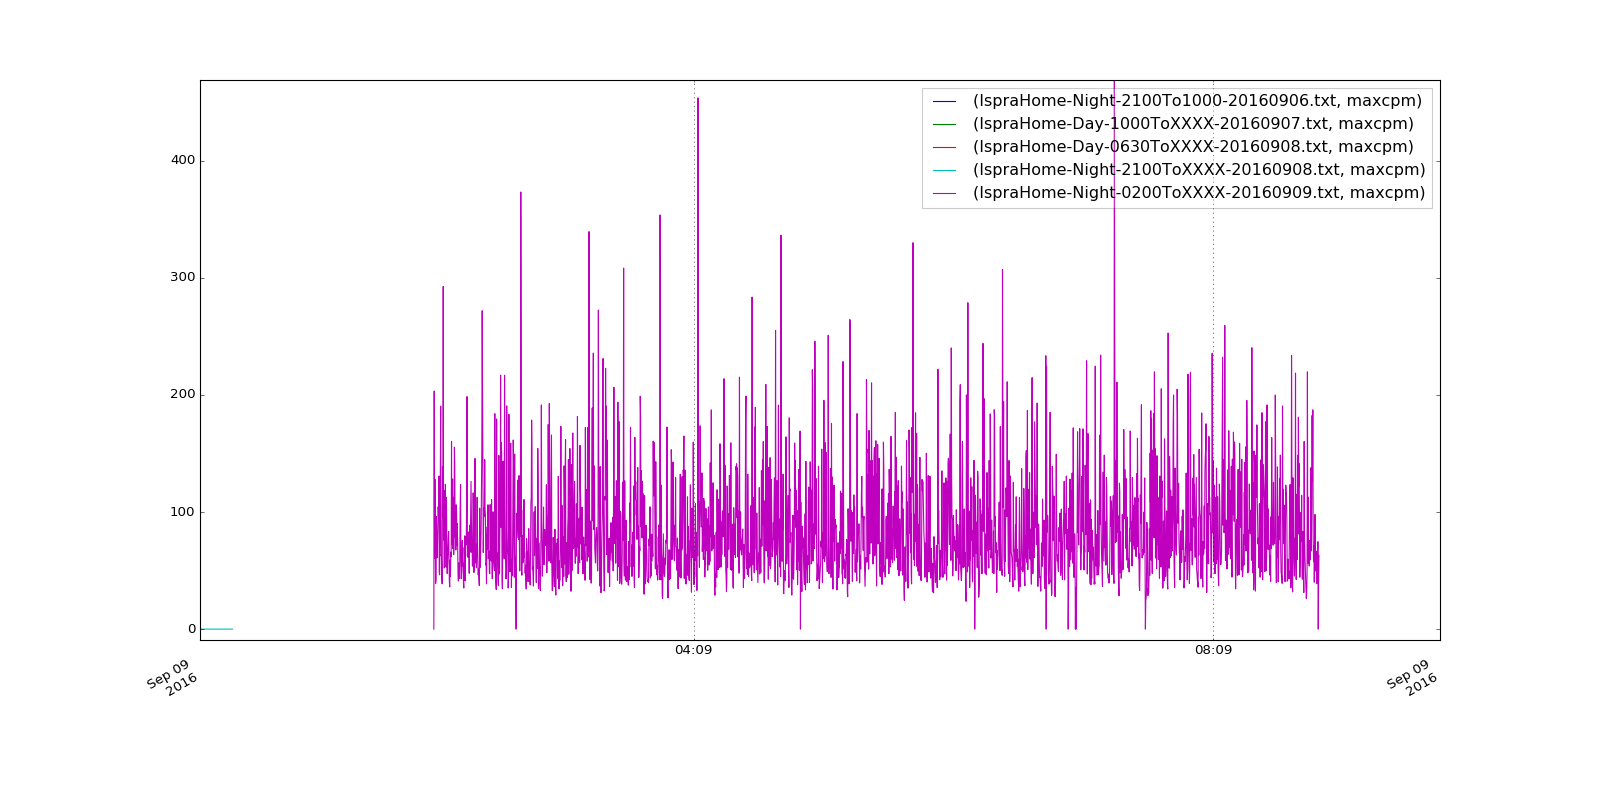

In [207]:
def plot_maxcpm(df):
    df.dropna(axis=0)
    ax = df.plot(figsize=(20, 10));
    ax.legend(framealpha=0.2);
    # From http://stackoverflow.com/a/13674286/548792
    ax.xaxis.set_minor_locator(dates.AutoDateLocator())
    ax.xaxis.set_minor_locator(dates.HourLocator(range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%m'))
    ax.xaxis.set_major_locator(dates.HourLocator(range(0, 24, 12)))
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b %d\n%Y'))
    ax.xaxis.grid(True, which="minor")


%matplotlib notebook
plot_maxcpm(df.loc[:, (slice(None), 'maxcpm')])

In [206]:
2362/6/60

6.561111111111112

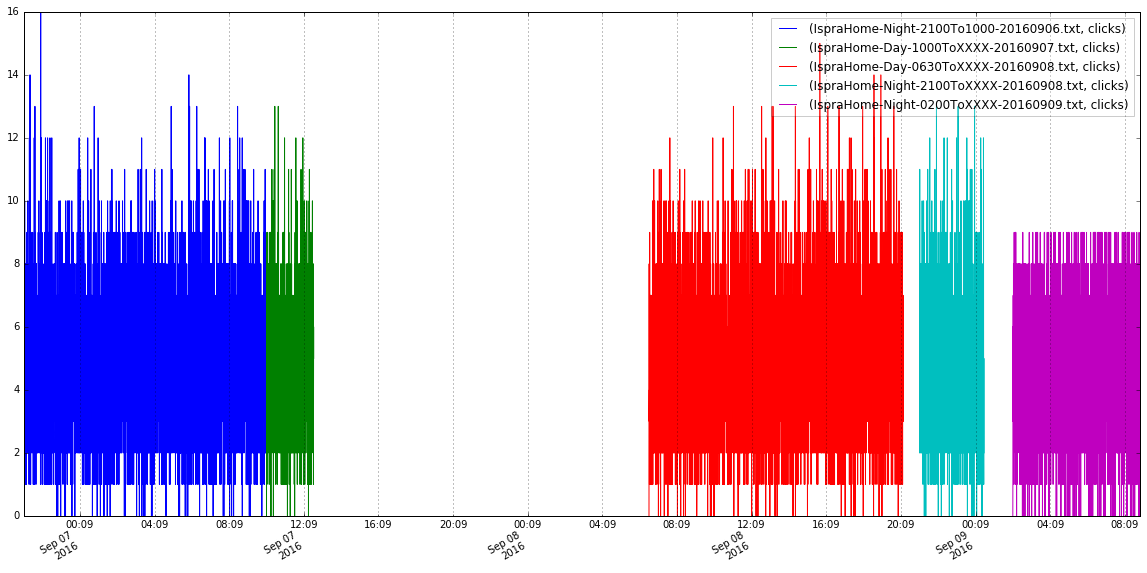

In [205]:
import matplotlib.dates as dates

def plot_clicks(df):
    smooth_nsamples = 60 # 60-->10min
    df2 = pd.rolling_mean(df, smooth_nsamples) * 6
    ax = df2.plot(figsize=(20, 10));
    ax.legend(framealpha=0.2);
    # From http://stackoverflow.com/a/13674286/548792
    ax.xaxis.set_minor_locator(dates.AutoDateLocator())
    ax.xaxis.set_minor_locator(dates.HourLocator(range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%m'))
    ax.xaxis.set_major_locator(dates.HourLocator(range(0, 24, 12)))
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%b %d\n%Y'))
    ax.xaxis.grid(True, which="minor")

plot_maxcpm(df.loc[:, (slice(None), 'clicks')])


ddsfds

dsf

ds

dsf

dsf

sdf

sf

df

dsf

sdf

ds

fd

fsdf

sdf

dsf

dsf

sd

d